# **Machine Learning for Churn Prediction**

This notebook encompass data transformation for model creation, model creation, model selection, hiperparameter optimization and model saving.

Importing necessary libraries and the Python file, `helper.py`, containing functions designed for a more streamlined and readable code.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor


# importing python file helpers_2.py
from helpers import *
from helpers_2 import *

In [2]:
SEED = 20
np.random.seed(SEED)

In [3]:
data = pd.read_csv('data/encoded_churn_data.csv')
data.drop(columns=['customerID'], inplace=True) # Dropping the customerID column
data.head()

,Churn,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,...,account_Charges_Monthly,account_Charges_Total,customer_gender_Male,internet_InternetService_Fiber optic,internet_InternetService_No,account_Contract_One year,account_Contract_Two year,account_PaymentMethod_Credit card (automatic),account_PaymentMethod_Electronic check,account_PaymentMethod_Mailed check
0,0,0,1,1,9,1,0,0,1,0,...,65.6,593.30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,0,0,0,9,1,1,0,0,0,...,59.9,542.40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,4,1,0,0,0,1,...,73.9,280.85,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,1,0,13,1,0,0,1,1,...,98.0,1237.85,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,1,0,3,1,0,0,0,0,...,83.9,267.40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Creating Potential new features for fitting our ML models

In [4]:
data['Average monthly spend'] = data['account_Charges_Total'] / data['customer_tenure']
data['Average monthly spend'].fillna(0, inplace=True)
data['Average monthly Spend - Present monthly spend'] = data['Average monthly spend'] - data['account_Charges_Monthly']

In [5]:
data.columns

Index(['Churn', 'customer_SeniorCitizen', 'customer_Partner',
       'customer_Dependents', 'customer_tenure', 'phone_PhoneService',
       'phone_MultipleLines', 'internet_OnlineSecurity',
       'internet_OnlineBackup', 'internet_DeviceProtection',
       'internet_TechSupport', 'internet_StreamingTV',
       'internet_StreamingMovies', 'account_PaperlessBilling',
       'account_Charges_Monthly', 'account_Charges_Total',
       'customer_gender_Male', 'internet_InternetService_Fiber optic',
       'internet_InternetService_No', 'account_Contract_One year',
       'account_Contract_Two year',
       'account_PaymentMethod_Credit card (automatic)',
       'account_PaymentMethod_Electronic check',
       'account_PaymentMethod_Mailed check', 'Average monthly spend',
       'Average monthly Spend - Present monthly spend'],
      dtype='object')

## **Scaling our Data**

In our dataset, we currently possess just three numeric variables. Nonetheless, it remains crucial to standardize our data, ensuring uniform scales across these variables. This is imperative due to the impact that data scale can have on certain models. Specifically, the scale of the data can inadvertently assign higher weights to variables, not because of their explanatory power in relation to the dependent variable, but simply due to their scale.

In [6]:
scaler = MinMaxScaler ()

num_cols = ['customer_tenure', 'account_Charges_Monthly','account_Charges_Total', 'Average monthly spend', 'Average monthly Spend - Present monthly spend']

data[num_cols] = scaler.fit_transform(data[num_cols])
data[num_cols].head()

,customer_tenure,account_Charges_Monthly,account_Charges_Total,Average monthly spend,Average monthly Spend - Present monthly spend
0,0.125000,0.471144,0.068315,0.543017,0.813757
1,0.125000,0.414428,0.062454,0.496431,0.814202
2,0.055556,0.553731,0.032338,0.578357,0.773559
3,0.180556,0.793532,0.142531,0.784343,0.782649
4,0.041667,0.653234,0.030789,0.734212,0.862991


## **Balacing dependent variable**

In our previous data cleansing and exploration phase, it became evident that our dependent variable (y) suffered from an imbalance. As a result, we meticulously selected the most suitable method for addressing this issue: undersampling through the utilization of SMOTE.

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)

In [8]:
X = data.drop(columns='Churn')
y = data['Churn']


smote = SMOTE()

# Fit and resample the data
X_resampled, y_resampled = smote.fit_resample(X, y)

data_balanced = pd.concat([y_resampled, X_resampled], axis=1)
data_balanced.head()

,Churn,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,...,customer_gender_Male,internet_InternetService_Fiber optic,internet_InternetService_No,account_Contract_One year,account_Contract_Two year,account_PaymentMethod_Credit card (automatic),account_PaymentMethod_Electronic check,account_PaymentMethod_Mailed check,Average monthly spend,Average monthly Spend - Present monthly spend
0,0,0,1,1,0.125000,1,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.543017,0.813757
1,0,0,0,0,0.125000,1,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.496431,0.814202
2,1,0,0,0,0.055556,1,0,0,0,1,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.578357,0.773559
3,1,1,1,0,0.180556,1,0,0,1,1,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.784343,0.782649
4,1,1,1,0,0.041667,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.734212,0.862991


Visualizing the new balanced data distribution

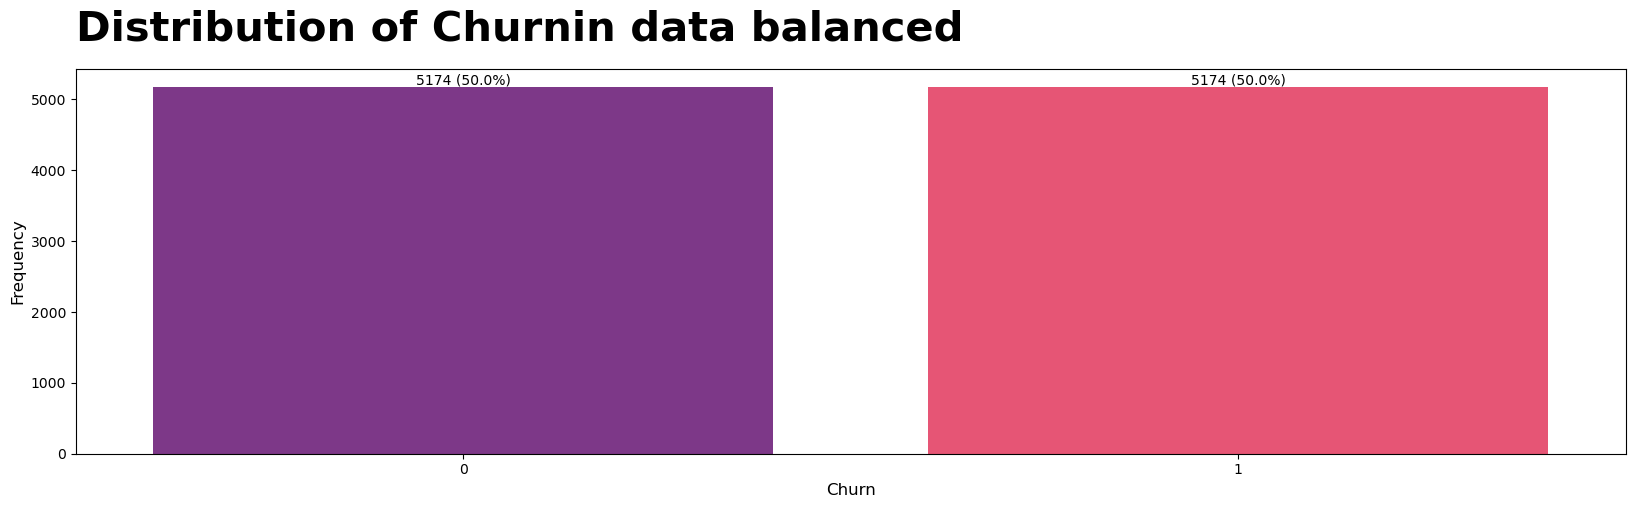

In [9]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='Churn', data=data_balanced, palette=binary_palette)
ax.set_title('Distribution of Churnin data balanced', size=30, loc='left', fontweight='bold', pad=20)
ax.set_xlabel('Churn', size=12)
ax.set_ylabel('Frequency', size=12)

label_bars(ax) # function to label the data


plt.show()

## **Creating, Selecting and Optimizing models**

Before diving into the process of model creation, selection, and optimization, one must first identify a primary metric that resonates with the specific context at hand. For classification models, a range of metrics such as accuracy, precision, recall, F1-score, and the area under the ROC curve (AUC-ROC) can be pivotal. However, the selection of the paramount metric should align with the unique objectives and stipulations of your project.

``Metric to prioritize: Recall.``

But why emphasize recall?

**Churn Implications:** In our scenario, overlooking a potential churn (a false negative) has more severe consequences than mistakenly predicting one (a false positive). This is because recall captures the fraction of actual positives correctly identified by the model. In today's competitive landscape, the cost associated with acquiring a new customer is significantly higher than retaining an existing one. Therefore, optimizing recall becomes pivotal, ensuring we don't miss out on opportunities to retain valuable customers.

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Importing models to be fitted
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

### **Creating Base-line models**

Instancing initial models for base line measurement

In [11]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=SEED)

# Random Forest Classifier
random_forest = RandomForestClassifier(random_state=SEED)

# Logistic Regression
logistic_regression = LogisticRegression(random_state=SEED, max_iter=1000)

# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Support Vector Machine Classifier
svc = SVC(random_state=SEED)

# Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(random_state=SEED)

# Gaussian Naive Bayes
gaussian_nb = GaussianNB()

# AdaBoost Classifier
adaboost = AdaBoostClassifier(random_state=SEED)

# Multi-layer Perceptron Classifier
mlp = MLPClassifier(early_stopping=True, random_state=SEED)

# storing models in a list for looping
models = [
    decision_tree,
    random_forest,
    logistic_regression,
    knn,
    svc,
    gradient_boosting,
    gaussian_nb,
    adaboost,
    mlp
]

Using all the feature from data_balanced DataFame to fit the model using Cross Validation method for a base-line measurument, and compare the results

In [12]:
# Splitting the dataset into X (features) and y (target)
X = data_balanced.drop(columns='Churn')
y = data_balanced['Churn']

In [13]:
base_line_models = fit_multiple_models_with_cv(models, X, y)
base_line_models

,Model,Fitting Time,Average Recall,Average F1,Average Accuracy,Average Precision
3,KNeighborsClassifier,0.007151,0.908974,0.823364,0.805279,0.752858
1,RandomForestClassifier,1.963438,0.872259,0.847316,0.845193,0.827174
5,GradientBoostingClassifier,2.888159,0.842496,0.811720,0.807504,0.786699
7,AdaBoostClassifier,0.770426,0.842298,0.808132,0.801899,0.779089
4,SVC,3.009393,0.831283,0.805091,0.799869,0.781824
2,LogisticRegression,0.099992,0.820457,0.796348,0.791461,0.774948
6,GaussianNB,0.006621,0.812336,0.779478,0.770683,0.749728
8,MLPClassifier,1.566637,0.811761,0.794092,0.790591,0.778492
0,DecisionTreeClassifier,0.107483,0.781616,0.772477,0.772522,0.767271


The best models were:

- KNeighbor
- Random Forest

#### Feature Selection

Feature selection can enhance model performance, mitigate overfitting, and, in larger datasets, expedite training times. For our specific scenario, the primary focus is on improving performance. Given the modest size of our dataset, training time is of minimal concern.

##### Correlation (Heatmap) and VIF (Variance Inflation Factor)

We can visualize that we might have some problems of multicolinearity

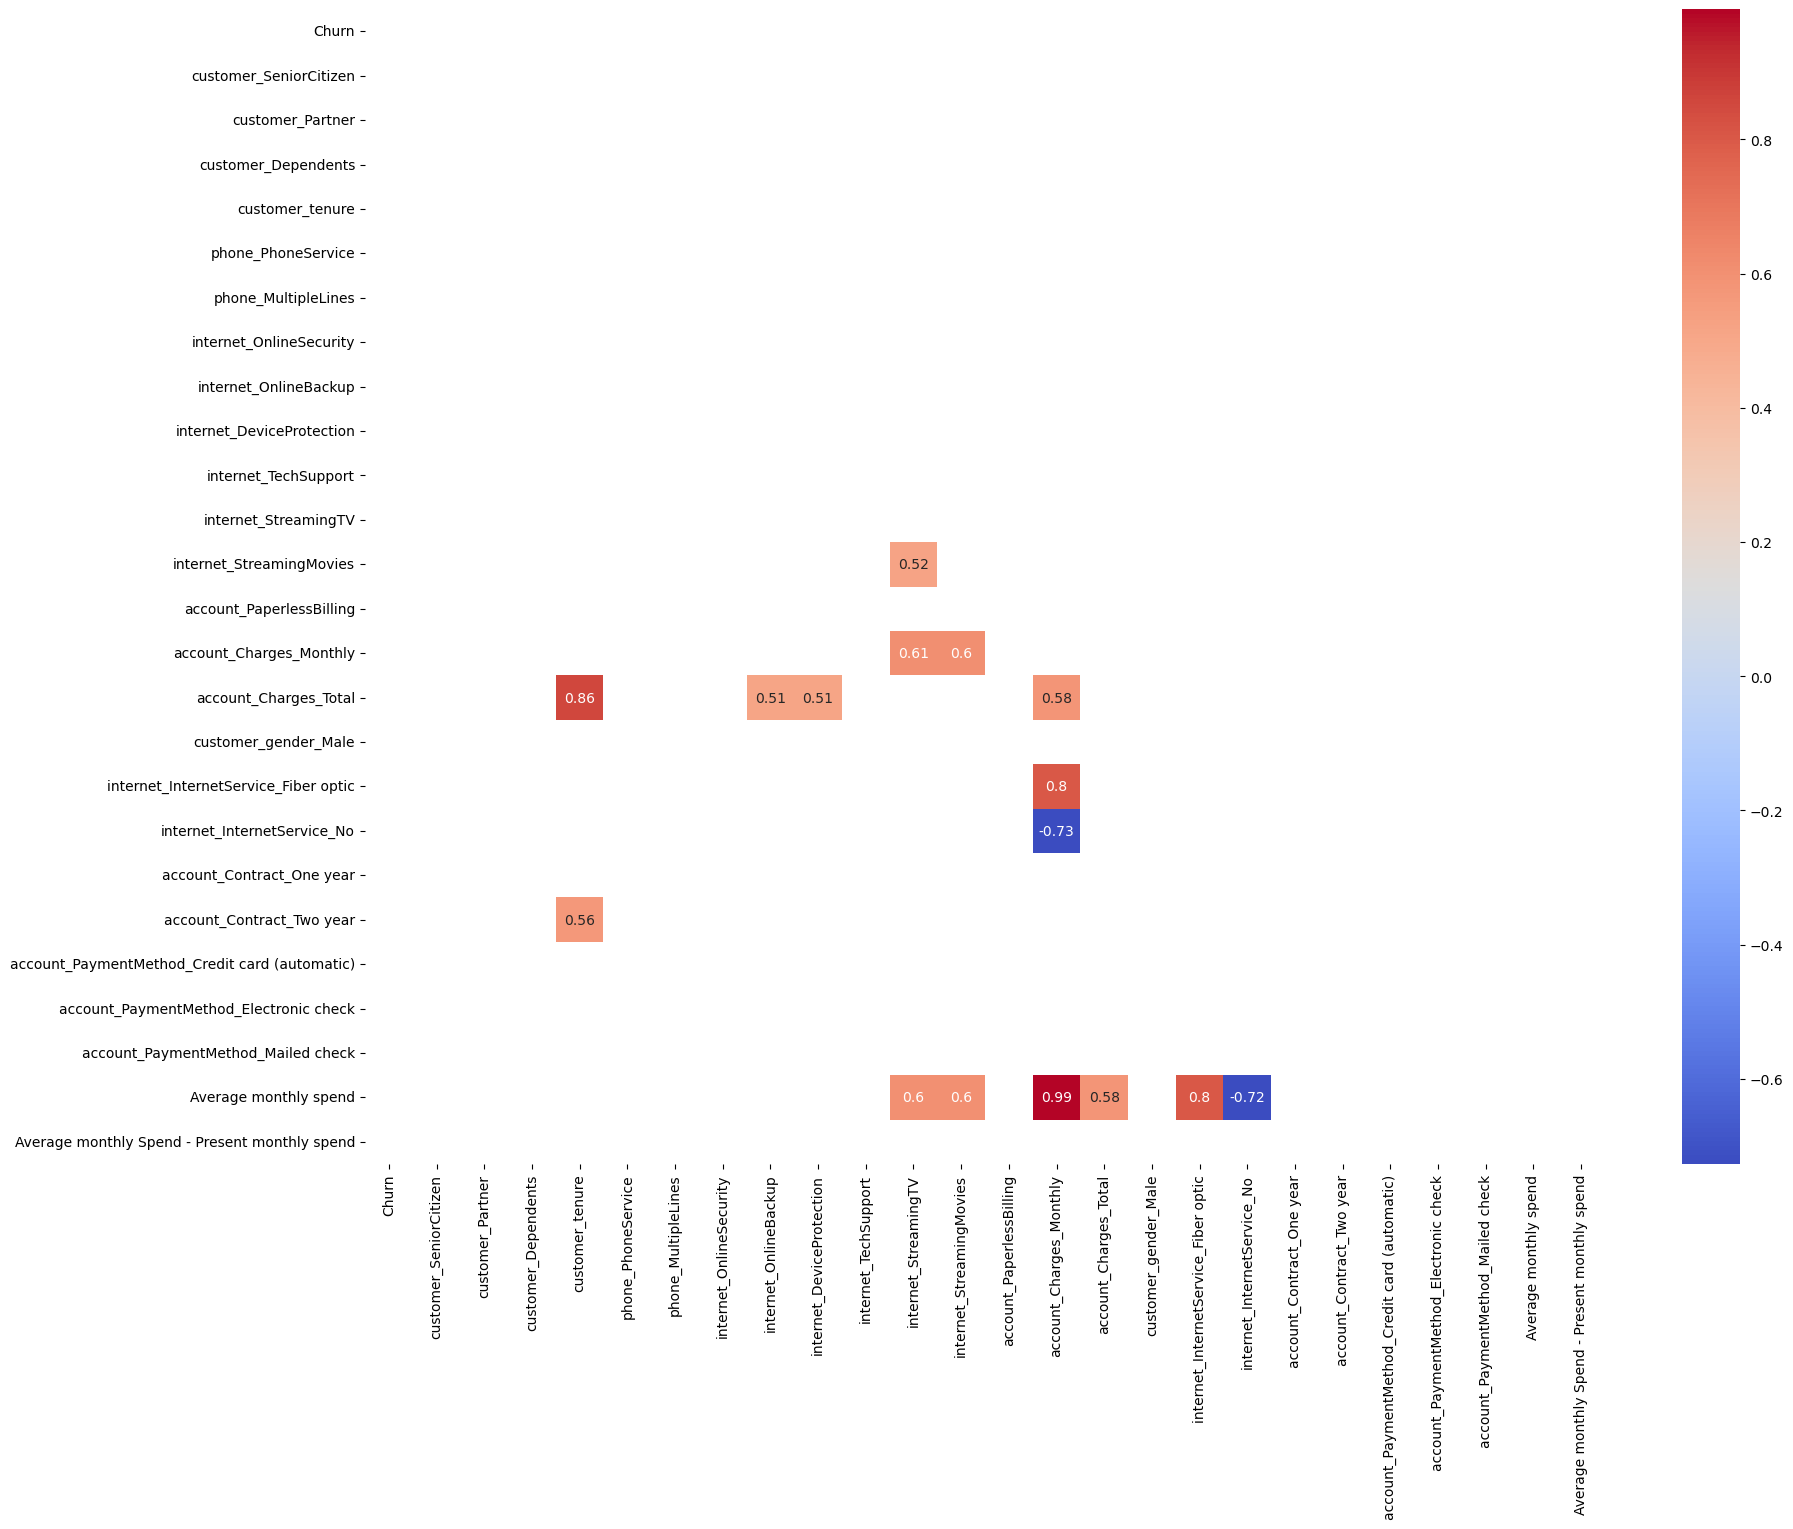

In [14]:
plot_heat_map(data_balanced, threshold=0.5)

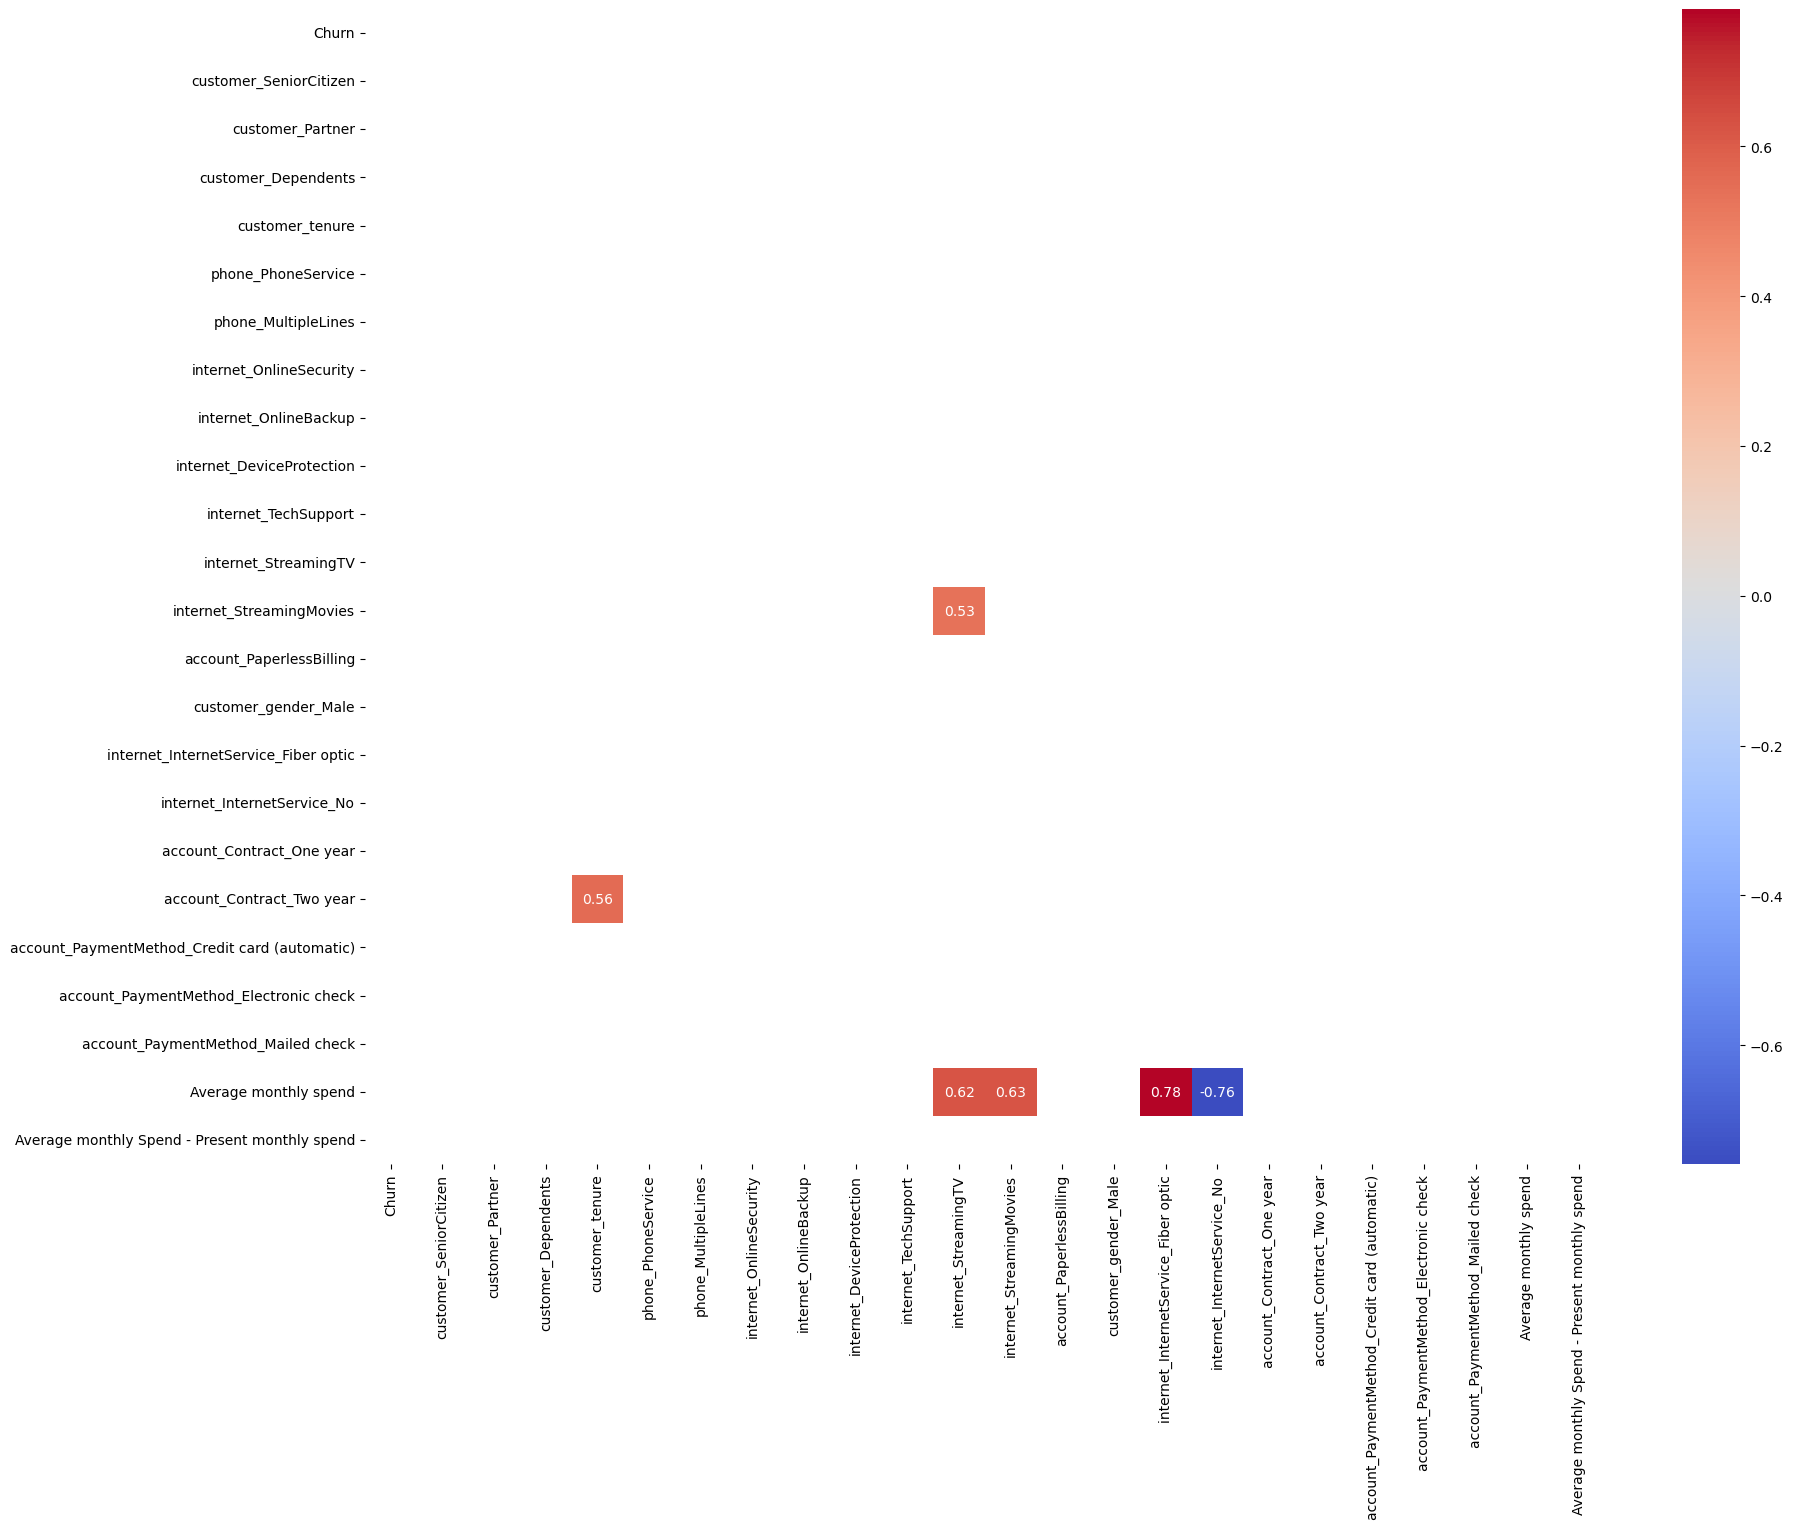

In [15]:
plot_heat_map(data.drop(columns=['account_Charges_Monthly', 'account_Charges_Total']))

I calculated the VIF (Variance Inflation Factor) and continuously dropped the variable with the highest VIF value. This process was repeated until no VIF value approached 10, which is considered a suitable threshold.

In [16]:
X = data.drop(columns = ['Churn', 'account_Charges_Monthly', 'Average monthly spend', 'Average monthly Spend - Present monthly spend', 'account_Charges_Total', 'phone_PhoneService'])
  
# Creating VIF DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                          feature       VIF
0                          customer_SeniorCitizen  1.362528
1                                customer_Partner  2.812840
2                             customer_Dependents  1.955141
3                                 customer_tenure  7.392978
4                             phone_MultipleLines  2.306164
5                         internet_OnlineSecurity  1.900309
6                           internet_OnlineBackup  2.083109
7                       internet_DeviceProtection  2.239682
8                            internet_TechSupport  2.022965
9                            internet_StreamingTV  2.636591
10                       internet_StreamingMovies  2.658620
11                       account_PaperlessBilling  2.658405
12                           customer_gender_Male  1.886287
13           internet_InternetService_Fiber optic  2.894843
14                    internet_InternetService_No  2.532006
15                      account_Contract

Removing the variable that resulted in a lower VIF factor actually diminished our model's performance, as illustrated in the table below

In [17]:
X = data_balanced.drop(columns=['Churn', 'account_Charges_Monthly', 'Average monthly spend', 'Average monthly Spend - Present monthly spend', 'account_Charges_Total', 'phone_PhoneService'])

test_vif = fit_multiple_models_with_cv(models, X, y)
test_vif

,Model,Fitting Time,Average Recall,Average F1,Average Accuracy,Average Precision
3,KNeighborsClassifier,0.004794,0.873797,0.810712,0.796389,0.756838
1,RandomForestClassifier,1.057875,0.864144,0.842305,0.841134,0.825753
5,GradientBoostingClassifier,1.072473,0.845588,0.815981,0.812143,0.791430
7,AdaBoostClassifier,0.427134,0.837080,0.806331,0.800159,0.778994
4,SVC,2.626971,0.828770,0.802337,0.796873,0.778733
6,GaussianNB,0.006369,0.812724,0.780390,0.771939,0.751275
2,LogisticRegression,0.031875,0.804026,0.783458,0.778221,0.764415
8,MLPClassifier,0.976138,0.795136,0.780537,0.776770,0.766780
0,DecisionTreeClassifier,0.040324,0.780268,0.775560,0.780158,0.778630


Eliminating the three variables with the highest VIF values led to a slight decline in model performance

In [18]:
X = data_balanced.drop(columns=['Churn', 'account_Charges_Monthly', 'Average monthly spend', 'Average monthly Spend - Present monthly spend',])

test_vif_2 = fit_multiple_models_with_cv(models, X, y)
test_vif_2

,Model,Fitting Time,Average Recall,Average F1,Average Accuracy,Average Precision
3,KNeighborsClassifier,0.004425,0.904530,0.822043,0.804506,0.753842
1,RandomForestClassifier,1.231305,0.860278,0.840911,0.839878,0.826243
5,GradientBoostingClassifier,1.560143,0.845974,0.815914,0.811853,0.791261
7,AdaBoostClassifier,0.517667,0.839207,0.806589,0.800256,0.778028
4,SVC,2.717908,0.829543,0.803937,0.798709,0.781074
2,LogisticRegression,0.041744,0.813884,0.788282,0.781990,0.764804
6,GaussianNB,0.006938,0.810983,0.780358,0.772229,0.752620
8,MLPClassifier,1.248967,0.794177,0.783029,0.781314,0.774312
0,DecisionTreeClassifier,0.056543,0.781035,0.778925,0.782477,0.782156


Eliminating the tow variables with the highest VIF values led to a slight incline for some models performance (recall and f1). Therefore we are going to continue with this set of X variables to optimize our models.

In [19]:
X = data_balanced.drop(columns=['Churn','account_Charges_Monthly', 'account_Charges_Total'])


test_vif_3 = fit_multiple_models_with_cv(models, X, y)
base_line_models_prefixed = base_line_models.add_prefix('baseline_')
compare = pd.concat([test_vif_3, base_line_models_prefixed], axis=1)
compare

,Model,Fitting Time,Average Recall,Average F1,Average Accuracy,Average Precision,baseline_Model,baseline_Fitting Time,baseline_Average Recall,baseline_Average F1,baseline_Average Accuracy,baseline_Average Precision
3,KNeighborsClassifier,0.004853,0.908201,0.823729,0.805956,0.754045,KNeighborsClassifier,0.007151,0.908974,0.823364,0.805279,0.752858
1,RandomForestClassifier,1.401861,0.875161,0.851734,0.850412,0.833534,RandomForestClassifier,1.963438,0.872259,0.847316,0.845193,0.827174
5,GradientBoostingClassifier,2.086419,0.851580,0.816161,0.810983,0.786826,GradientBoostingClassifier,2.888159,0.842496,0.811720,0.807504,0.786699
7,AdaBoostClassifier,0.643767,0.846165,0.810346,0.803638,0.779707,AdaBoostClassifier,0.770426,0.842298,0.808132,0.801899,0.779089
4,SVC,2.892090,0.828770,0.803212,0.798032,0.780511,SVC,3.009393,0.831283,0.805091,0.799869,0.781824
8,MLPClassifier,1.914280,0.818333,0.793598,0.788366,0.772137,MLPClassifier,1.566637,0.811761,0.794092,0.790591,0.778492
6,GaussianNB,0.008323,0.814076,0.780938,0.772229,0.751029,GaussianNB,0.006621,0.812336,0.779478,0.770683,0.749728
2,LogisticRegression,0.068762,0.808860,0.788290,0.783729,0.769860,LogisticRegression,0.099992,0.820457,0.796348,0.791461,0.774948
0,DecisionTreeClassifier,0.069050,0.777748,0.773378,0.775323,0.774153,DecisionTreeClassifier,0.107483,0.781616,0.772477,0.772522,0.767271


#### **Optimizing the selected models**

To prevent overfitting, it's advisable to partition your data: one portion for hyperparameter optimization and another to assess the model's performance on unseen data. To accomplish this, we will employ a Nested Cross-Validation loop. This approach comprises an outer CV, which evaluates the model's performance, and an inner CV, which optimizes the hyperparameters.

Producing: "Under this procedure, hyperparameter search does not have an opportunity to overfit the dataset as it is only exposed to a subset of the dataset provided by the outer cross-validation procedure. This reduces, if not eliminates, the risk of the search procedure overfitting the original dataset and should provide a **less biased estimate of a tuned model’s performance on the dataset**."

For a deeper dive into this topic, feel free to explore my GitHub repository on [Cross Validation](https://github.com/Lacerdash/Nested-Cross-Validation) and this [article about Nested Cross Validation](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

Defining the X (features) we are going to use

In [ ]:
X = data_balanced.drop(columns=['Churn','account_Charges_Monthly', 'account_Charges_Total'])

##### Optimizing Random Forest

Creating the Param Grid for Random Forest Clasifier that we are going to look through

In [23]:
# Random Forest ParamGrid
rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
              'max_features': ['log2', 'sqrt'],
              'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
              'min_samples_leaf' : [1, 2, 4],
              'min_samples_split': [3, 5, 10],
              'criterion': ['gini', 'entropy'],
              'bootstrap': [True, False]
              }

Using ``randomized_grid_search_wrapper`` function from [`helpers_2.py`](https://github.com/Lacerdash/ML-for-Churn-predicting/blob/master/helpers_2.py) to conduct a RandomizedSearchCV. This identifies the best hyperparameters for our desired metric: *recall*.

In [85]:
rf_rs_results = randomized_grid_search_wrapper(random_forest, X, y, rf_param_grid, n_iter=5, refit_score='recall')

Visualizing the best models by recall we see that the best model was: 

In [86]:
rf_rs_models = pd.DataFrame(rf_rs_results.cv_results_)
rf_rs_models.columns
rf_rs_models.sort_values(by=['mean_test_recall', 'mean_fit_time'], ascending=[False, True])[['mean_fit_time', 'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_features', 'param_max_depth',
       'param_criterion', 'param_bootstrap', 'mean_test_recall']].head()

,mean_fit_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,mean_test_recall
2,61.718775,1800,5,2,log2,40,entropy,False,0.872244
3,37.286876,1200,5,2,sqrt,100,entropy,True,0.870119
0,32.618195,1600,5,2,log2,10,gini,False,0.869154
4,5.806208,200,3,4,sqrt,90,gini,False,0.867027
1,15.573885,400,5,1,log2,60,entropy,False,0.866832


We will proceed with the model below because it achieved a comparable recall while requiring significantly less fit time.

In [88]:
print(rf_rs_results.best_estimator_)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=40,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1800, random_state=20)


Now, we will implement the **Nested Cross Validation** approach. This method provides a more accurate and less biased performance assessment for our tuned model. While we'll proceed with the best model identified in the previous code, it's essential to understand that **Nested Cross Validation primarily offers a more accurate performance of a tuned model’s performance on the dataset**

In [78]:
inner_cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
outer_cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)

rf_hp_search = RandomizedSearchCV(RandomForestClassifier(random_state=SEED), 
                               param_distributions=rf_param_grid, 
                               n_iter= 50,
                               scoring=scorers,
                               refit='recall', 
                               cv = inner_cv,
                               random_state=SEED)

rf_results = cross_validate(rf_hp_search, X, y, cv=outer_cv, 
                         scoring=['recall', 'f1', 'accuracy', 'precision'],
                         n_jobs=-1)

# Display results
print('These the average results we can expect from our optimized model')
for metric, scores in rf_results.items():
    if "test_" in metric:  # we only want to print the test scores
        print(f'{metric}: Mean: {np.mean(scores):.3f}, Scores: {scores.round(3)}')

These the average results we can expect from our optimized model
test_recall: Mean: 0.871, Scores: [0.867 0.874 0.869 0.864 0.879]
test_f1: Mean: 0.846, Scores: [0.827 0.854 0.845 0.847 0.857]
test_accuracy: Mean: 0.842, Scores: [0.819 0.851 0.841 0.844 0.854]
test_precision: Mean: 0.823, Scores: [0.792 0.835 0.823 0.831 0.836]


Comparing the best model with our base line model

In [79]:
rf_best_estimator = rf_rs_results.best_estimator_
rf_best_model = fit_model_with_cv(rf_best_estimator, X, y)
rf_best_model_metrics = [get_metrics_from_cross_validate(rf_best_model)]

rf_best_estimator_df = pd.DataFrame(rf_best_model_metrics, columns=['fit_time', 'avg_recall', 'avg_f1', 'avg_accuracy', 'avg_precision'], index=['rf_best_model'])
rf_best_estimator_df

,fit_time,avg_recall,avg_f1,avg_accuracy,avg_precision
rf_best_model,39.545797,0.881151,0.851835,0.849252,0.82788


In [80]:
rf_base_line = fit_model_with_cv(random_forest, X, y)
get_metrics_from_cross_validate(rf_base_line)


rf_base_line = fit_model_with_cv(random_forest, X, y)
rf_base_line_model_metrics = [get_metrics_from_cross_validate(rf_base_line)]

rf_base_line_model_df = pd.DataFrame(rf_base_line_model_metrics, columns=['fit_time', 'avg_recall', 'avg_f1', 'avg_accuracy', 'avg_precision'], index=['rf_base_line_model'])

pd.concat([rf_best_estimator_df, rf_base_line_model_df])

,fit_time,avg_recall,avg_f1,avg_accuracy,avg_precision
rf_best_model,39.545797,0.881151,0.851835,0.849252,0.827880
rf_base_line_model,2.364225,0.872259,0.847316,0.845193,0.827174


We were able to improve our model peformance in every metric, by doing a simple Randomized Search

##### Optimizing KNN Classifier

Creating the Param Grid for KNN Classifier that we are going to look through

In [ ]:
knn_param_grid = {'n_neighbors': np.arange(2, 10, step=2),
            'weights': ['uniform','distance'],
            'algorithm': ['auto','ball_tree', 'brute'],
            'metric' : ['euclidean', 'minkowski', 'chebyshev', 'braycurtis']
            }

Using ``randomized_grid_search_wrapper`` function from [`helpers_2.py`](https://github.com/Lacerdash/ML-for-Churn-predicting/blob/master/helpers_2.py) to conduct a RandomizedSearchCV. This identifies the best hyperparameters for our desired metric: *recall*.

In [96]:
knn_rs_result = randomized_grid_search_wrapper(knn, X, y, knn_param_grid, n_iter=96, refit_score='recall')

Visualizing the best models by recall

In [97]:
knn_rs_models = pd.DataFrame(knn_rs_result.cv_results_)
knn_rs_models.sort_values(by=['mean_test_recall', 'mean_fit_time'], ascending=[False, True])[['mean_fit_time', 'param_algorithm', 'param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_recall']].head()

,mean_fit_time,param_algorithm,param_metric,param_n_neighbors,param_weights,mean_test_recall
47,0.139566,ball_tree,minkowski,8,distance,0.907421
39,0.240130,ball_tree,euclidean,8,distance,0.907421
15,0.009125,auto,minkowski,8,distance,0.907227
71,0.009425,brute,euclidean,8,distance,0.907227
7,0.009826,auto,euclidean,8,distance,0.907227


We will proceed with the model below because it achieved a comparable recall while requiring significantly less fit time.

In [98]:
print(knn_rs_result.best_estimator_)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_jobs=-1,
                     n_neighbors=8, weights='distance')


Now, we will implement the Nested Cross Validation approach. This method provides a more accurate and less biased performance assessment for our tuned model. While we'll proceed with the best model identified in the previous code, it's essential to understand that Nested Cross Validation primarily offers a more accurate performance of a tuned model’s performance on the dataset

In [58]:
inner_cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
outer_cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)

knn_hp_search = RandomizedSearchCV(knn, 
                               param_distributions=knn_param_grid, 
                               n_iter=100, 
                               cv = inner_cv,
                               scoring=scorers,
                               refit='recall',
                               random_state=SEED,
                               n_jobs=-1)

knn_results = cross_validate(knn_hp_search, X, y, cv=outer_cv, 
                         scoring=['recall', 'f1', 'accuracy', 'precision'],
                         n_jobs=-1)

# Display results
for metric, scores in knn_results.items():
    if "test_" in metric:  # we only want to print the test scores
        print(f'{metric}: Mean: {np.mean(scores):.3f}, Scores: {scores.round(3)}')

test_recall: Mean: 0.903, Scores: [0.887 0.902 0.914 0.899 0.912]
test_f1: Mean: 0.823, Scores: [0.811 0.834 0.822 0.82  0.826]
test_accuracy: Mean: 0.805, Scores: [0.794 0.821 0.802 0.802 0.808]
test_precision: Mean: 0.756, Scores: [0.748 0.776 0.747 0.753 0.755]


In [99]:
knn_best_estimator = knn_rs_result.best_estimator_
knn_best_model = fit_model_with_cv(knn_best_estimator, X, y)
knn_best_model_metrics = [get_metrics_from_cross_validate(knn_best_model)]

knn_best_model_df = pd.DataFrame(knn_best_model_metrics, columns=['fit_time', 'avg_recall', 'avg_f1', 'avg_accuracy', 'avg_precision'], index=['knn_best_model'])
knn_best_model_df

,fit_time,avg_recall,avg_f1,avg_accuracy,avg_precision
knn_best_model,0.034441,0.916898,0.830749,0.813687,0.759873


In [100]:
knn_base_line = fit_model_with_cv(knn, X, y)
knn_base_line_metrics = [get_metrics_from_cross_validate(knn_base_line)]

knn_base_line_df = pd.DataFrame(knn_base_line_metrics, columns=['fit_time', 'avg_recall', 'avg_f1', 'avg_accuracy', 'avg_precision'], index=['knn_base_line_model'])

pd.concat([knn_best_model_df, knn_base_line_df])

,fit_time,avg_recall,avg_f1,avg_accuracy,avg_precision
knn_best_model,0.034441,0.916898,0.830749,0.813687,0.759873
knn_base_line_model,0.011400,0.908974,0.823364,0.805279,0.752858


In [101]:
pd.concat([rf_best_estimator_df, rf_base_line_model_df, knn_best_model_df, knn_base_line_df])

,fit_time,avg_recall,avg_f1,avg_accuracy,avg_precision
rf_best_model,39.545797,0.881151,0.851835,0.849252,0.827880
rf_base_line_model,2.364225,0.872259,0.847316,0.845193,0.827174
knn_best_model,0.034441,0.916898,0.830749,0.813687,0.759873
knn_base_line_model,0.011400,0.908974,0.823364,0.805279,0.752858


Between the Random Forest and KNN classifiers, we will opt for the Random Forest Classifier due to its significantly superior performance across various metrics, all while sustaining a high recall metric.

### Getting Feature importance 

Examining the feature importance attributed by different models (Logistic Regression and Random Forest), we observe distinct methods of evaluation. For the Logistic Regression model, feature importance is determined by the coefficient value of each variable. In contrast, the Random Forest model gauges feature importance based on the decrease in node impurity, typically measured using Gini impurity or entropy. This difference underscores the varied approaches these algorithms take in assigning significance to features, which can impact model interpretation and subsequent decision-making.

#### Random Forest Classifier Feature Importance

In [103]:
print(rf_best_estimator)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=40,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1800, random_state=20)


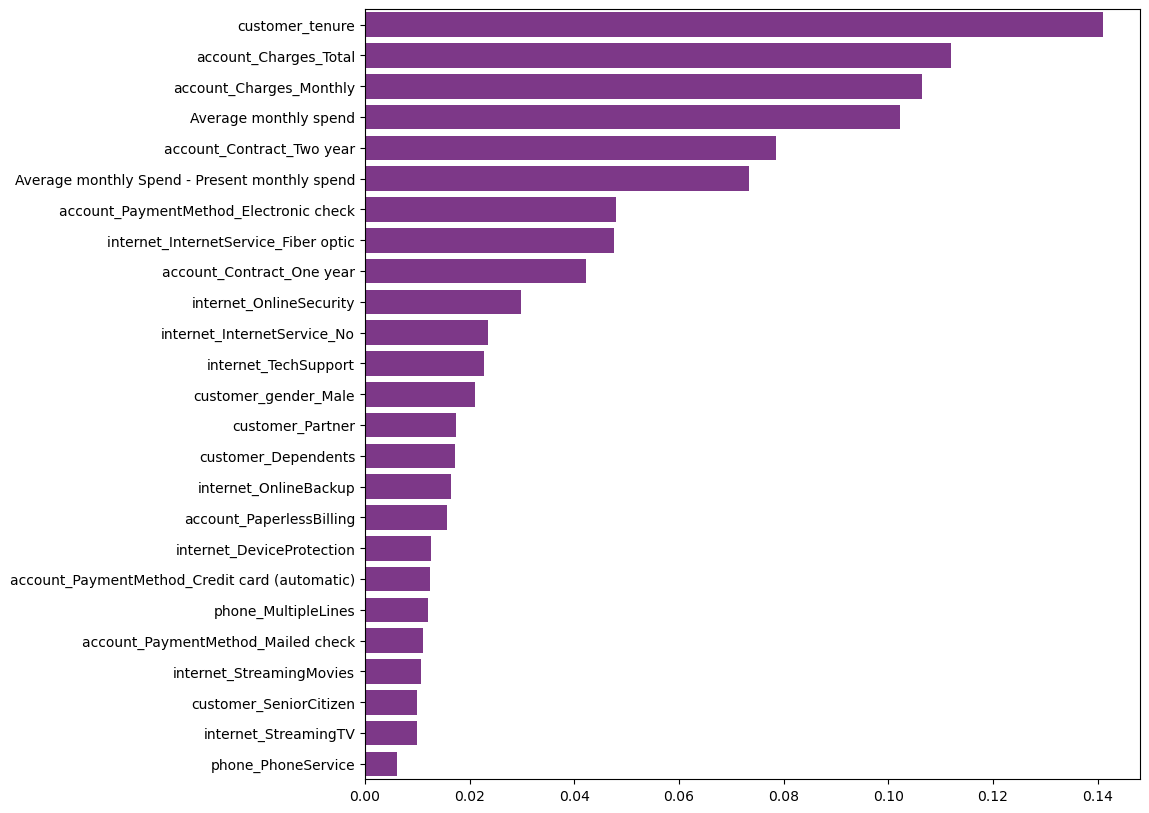

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

rf_best_estimator.fit(X_train, y_train)
y_pred = rf_best_estimator.predict(X_test)


recall = metrics.recall_score(y_test, y_pred) 
f1 = metrics.f1_score(y_test, y_pred)

# Get indices that would sort the feature importances
sorted_indices = np.argsort(rf_best_estimator.feature_importances_)[::-1]

plt.figure(figsize=(10,10))
sns.barplot(y=np.array(rf_best_estimator.feature_names_in_)[sorted_indices], 
            x=rf_best_estimator.feature_importances_[sorted_indices],
            color='#872b95')

plt.show()

#### Saving the Optimized Model

In [117]:
import joblib

model_name = type(rf_best_estimator).__name__
file_name = model_name + '_recall_' + str(round(recall, 4)) + '_f1_' + str(round(f1, 4)) +'.pkl'
joblib.dump(rf_best_estimator, file_name)

['RandomForestClassifier_recall_0.885_f1_0.8545.pkl']